# Feature Selection and Regularization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, LinearRegression, lasso_path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, make_scorer

pd.set_option('display.max_columns', 500)

%matplotlib inline

##### You're Still a Data Scientist!

Your models from the last assignment really impressed some in the management in your football club. Now that you have learned the art of regularization, your boss thinks you should do equally well with much less data. This will save a lot of money the next time around. This time you only get a data set with 3000 observations.

### Task1: Preprocessing (5 pts)

* Load the data present in 'footballer_small.csv' using the pandas library and store the loaded data in a dataframe
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**. If you want to understand why this is, have a look at the Jupyter notebook (`Ridge_And_Dummycoding.ipynb`).  
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0
* visualize all variables of the first 50 observations of the Training data set as an image (see Lab06_followalong). You can also look at it as a data frame. How are the different variables scaled? Which variables have high and which ones have low values?    

To make sure that you get a good start - check the solutions from Assignment 4. And make sure you can apply these steps flexibly and quickly. **You will need it for the midterm!**

(3000, 52)

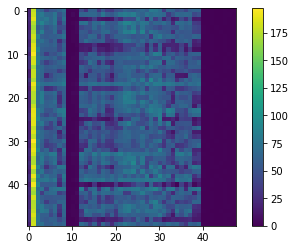

In [5]:
##### Your answer here
df = pd.read_csv('footballer_small.csv' )
display(df.shape)

df = df.drop(['ID','club','club_logo','birth_date',\
                              'flag','nationality','photo','potential'], axis='columns')
# display(df.head)


# df = pd.get_dummies(df,\
#            columns=['work_rate_att','work_rate_def','preferred_foot'])
df = pd.get_dummies(df)
# display(df.shape)

y = df.overall
X = df.drop('overall', axis='columns')
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size= 500, random_state = 0)

plt.imshow(Xtrain[:50])
plt.colorbar()

# display(img_rgb)

**Your written answer here** we introduced some dummy variables which are 0 or 1, therefore they have the lowest values in the data frame. The height column has the highest values all more than 150, which are shown with the lightest color. 

##### Question 2: Standardization  (10 pts)
When using regularized regression models, the scaling of the different regressors can influence the results dramatically (see lectures). One simple solution is to standardize all features before estimating the model, so that no feature can dominate others due to differences in feature scales. 

a) Use the sklearn class `StandardScaler` to produce a z-scale version of your training data set. Again visualize the the first 50 observations an image. Compare to the plot that you got in Question 1. What do you observe? 

b) Plot a histogram of the second column (height_cm) of the non-standarized and standardized training set. What is the mean and variance of the standardized training set. 

c) Build a model `pipeline` that first standarizes all the features in the training set and then fits a `LinearRegression` model. 


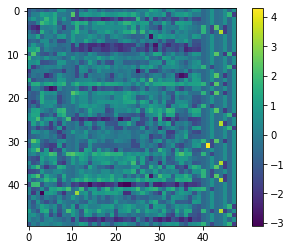

In [6]:
##### Part a answer
scaler = sk.preprocessing.StandardScaler(with_mean=True, with_std=True)
Xtrain_scl = scaler.fit_transform(Xtrain)
plt.imshow(Xtrain_scl[:50])
plt.colorbar()

 **Written answer here** Before scaling we had feature with high values that could dominate the effect of multiple features with small values close to zero. By standardization we scale all the parameters so that the weight of all their effects is similar.

The mean value for scaled height is :-1.5546675058430992e-15
The std for scaled height is :1.0


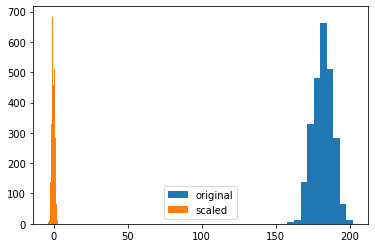

In [7]:
##### b) Plot historgram 
plt.hist(Xtrain.height_cm, label = 'original')

h = (Xtrain.columns.get_loc("height_cm"))

plt.hist(Xtrain_scl[:,h], label = 'scaled')
plt.legend()

print(f"The mean value for scaled height is :{Xtrain_scl[:,h].mean()}")
scl_std = Xtrain_scl[:,h].std() 
print(f"The std for scaled height is :{scl_std}")

In [ ]:
**Written answer here**

In [9]:
##### c: Build pipeline
model1 = Pipeline([
    ('scaler', sk.preprocessing.StandardScaler(with_mean=True, with_std=True)),
    ('linear_regression', LinearRegression())  
])

# model1.fit(Xtrain, ytrain)

##### Question 3: Comparing different complex features (10 pts)
In this task, we will first consider a model that includes all the variables in the data AND all quadratic terms (i.e. each features to the power of two, and the products (interactions) between all possible pairs of features. 

a) Generate a design matrix for the model. You can use sklearn's `PolynomialFeatures` to do the job. Because sklearn's linear models have the option to fit the intercept, internally, set the `include_bias` option to `False`. 
* How many linear terms are in each of the new feature set?
* How many squared terms are in each of the new feature set?
* How many interaction terms are in each of the new feature set? Give an example of one of the interaction terms. 

b) Now generate 3 more models / design matrices. Again it should include all quadratic terms and 2-way interactions - but each model should drop one of the features
* Second Model: Drop `standing_tackle`
* Third Model: Drop `composure`
* Fourth model: Drop `marking`

Hint: For these models, create the design matrix without the aforementioned features and then apply polynomial expansion to the remaing features. 


In [11]:
# a) Make the new expanded design matrix 
PT = PolynomialFeatures(degree=2, include_bias = False) # the intercept is always included
Xtrain_sqr1 = PT.fit_transform(Xtrain)
print(Xtrain_sqr1.shape)
print(Xtrain.shape)

(2500, 1224)
(2500, 48)


 **Written answer here** We have 48 linear terms, and 48 terms for squared value of each feature,  (48 * 48 (all mutual int.) - 48(squared))/2(for double counting)  = 1128 terms for interactions. 

In [12]:
##### Make design matrices without one of the features
# X2 = df.drop('overall', axis='columns')
Xtrain_sqr2 = PT.fit_transform(Xtrain.drop('standing_tackle', axis='columns'))

Xtrain_sqr3 = PT.fit_transform(Xtrain.drop('composure', axis='columns'))

Xtrain_sqr4 = PT.fit_transform(Xtrain.drop('marking', axis='columns'))

##### Question 4: Evaluating the backward feature search (15 pts)
In this question, you have to use the pipeline created in question 2 and apply it to each of the models in question 3. Use 10-fold cross validation to report the validation error on the models using mean squared error as the metric. <br>
Show all the steps of the process and compare and analyze the results using the validation error reported. For this first step in the backwards search, which feature would you drop? 

In [13]:
##### Your code here
def mse(y,ypred):
    return np.mean((y-ypred)**2)


kf = KFold(n_splits=10, shuffle = False)
sc = make_scorer(mse)

print(cross_val_score(model1, Xtrain_sqr2, ytrain, cv = kf, scoring = sc).mean())
print(cross_val_score(model1, Xtrain_sqr3, ytrain, cv = kf, scoring = sc).mean())
print(cross_val_score(model1, Xtrain_sqr4, ytrain, cv = kf, scoring = sc).mean())


2.7538344250119495
2.8059914662727947
2.696835775499225


In [14]:
# Now report test loss on model4, before that we need to Transform the Test data
Xtest_sqr4 = PT.fit_transform(Xtest.drop('marking', axis='columns'))

model = model1.fit(Xtrain_sqr4, ytrain)
testloss = mse(ytest, model.predict(Xtest_sqr4))
print(f"Test loss: {testloss}")

Test loss: 2.6302032381367537


**Written answer here**  Among three data sets, the one that `marking` has been droped has the lowest cross validation loss, so we refit our squared test data and dropped `marking` and the test loss is  2.6302032381367537

## Question 5: Applying Ridge Regression (10 pts)
Build a pipeline that performs scaling and fits the ridge regression on the data that includes the polynomial expansion of all the features. The ridge parameter ($\lambda$ or `alpha` in sklearn) should be set to 0.5. Use the pipeline to report the validation error using mean square error metric. Use 10-fold cross validation. 

In [17]:
# Your code here
model2 = Pipeline([
    ('Poly', PolynomialFeatures(degree=2, include_bias = False)),
    ('scaler', sk.preprocessing.StandardScaler(with_mean=True, with_std=True)),
    ('ridge', Ridge(alpha=0.5, fit_intercept = True)),
])


In [18]:
cv_scores = cross_val_score(model2, Xtrain, ytrain, cv=10, scoring='neg_mean_squared_error')
print(f"validation error is :{-cv_scores.mean()}")


validation error is :1.7146770020400566


## Question 6: Tune the Ridge coefficient for the 2nd-order model (15 pts)
Perform the search going from $\lambda = \exp(-8), \cdots, \exp(6)$ in 15 evenly spaced increments on the log scale. 

For each setting of lambda, calculate the training error when fitting the regularized model to the entire trainign data set, and the prediction error by studying the performance on the left-out part using 10-fold cross-validation. (*Note this calculation can take a bit, be patient*)

Plot the mean squared training error and mean squared validation error as a function of $\log(\lambda)$. 

Note: Although you can ultimately use `GridSearchCV` from sklearn, in this task you need to program a for-loop interating over all the levels of $\lambda$.  

### Questions: 

What is the best regularization parameter? 

Why does the validation error increase as $\lambda \rightarrow 0$, while the training error decreases from the optimal value?  Why does both the training and the validation error increase when $\lambda \rightarrow \infty$?  Answer in terms of the bias variance trade off and model complexity.


In [19]:
# Your code here
lam = np.exp(np.linspace(-8, 6, 15)) 

# lambda_lasso, coefs_lasso, _ = lasso_path(X, df.y, eps=0.005, n_alphas = 100, alphas = None, fit_intercepr = False)
cv_error = np.zeros(15)
pred_error = np.zeros(15)
j = 0

PT = PolynomialFeatures(degree=2, include_bias = False) # the intercept is always included

Xtrain_sqr = PT.fit_transform(Xtrain)
Xtrain_sqr_scl = scaler.fit_transform(Xtrain_sqr)

Xtest_sqr = PT.fit_transform(Xtest)
Xtest_sqr_scl = scaler.fit_transform(Xtest_sqr)

for i in range(lam.size):
    cv_error[i]=-cross_val_score(Ridge(alpha=lam[i]), Xtrain_sqr_scl, ytrain, cv=10, scoring='neg_mean_squared_error').mean()
    ridge = Ridge(alpha=lam[i], fit_intercept = True) 
    ridge.fit(Xtrain_sqr_scl, ytrain)
    ypp = ridge.predict(Xtest_sqr_scl)
    pred_error[i] = mse(ytest, ypp)


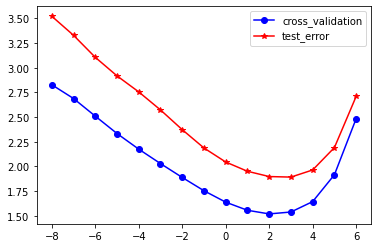

In [20]:
plt.plot(np.log(lam),cv_error, 'o-b', label='cross_validation')
plt.plot(np.log(lam),pred_error, '*-r', label='test_error')
plt.legend()

**Written answer here** `lambda`=np.exp(2) gives the lowest prediction error. when `lambda` =>0 it means there is no regularization and we are reporting a linear regression with the squared parameteres. when none of the coeficients is shrunked much. 
when `lambda` => inf we have the case of overfitting, as we see the cross validation remains small but the test_error increases.
By increasing the `lambda` we are getting smaller variance but a more biased result.

In [21]:
for i in range(lam.size):
    print(lam[i])

0.00033546262790251185
0.0009118819655545162
0.0024787521766663585
0.006737946999085467
0.01831563888873418
0.049787068367863944
0.1353352832366127
0.36787944117144233
1.0
2.718281828459045
7.38905609893065
20.085536923187668
54.598150033144236
148.4131591025766
403.4287934927351


## Question 7: Test error  (10 pts)
Now fit the model using ridge regression, using the lambda-value that you determined works best (in terms of crossvalidated mse) from Question 6. Fit the model on the whole training set. 

Report the mean squared error on the test data - along with the 95% confidence interval, determined with the central limit theorem (remember assignment 5). 

In [24]:
# Your code here
ridge = Ridge(alpha=np.exp(2), fit_intercept = True) 
ridge.fit(Xtrain_sqr_scl, ytrain)
ypp = ridge.predict(Xtest_sqr_scl)

mse_test = mse(ytest, ypp)

sqrd_error = (ytest - ypp)**2
std_mean_error = np.std(sqrd_error) * 1.96/ np.sqrt(len(sqrd_error))
CI = [mse_test - std_mean_error, mse_test + std_mean_error]

print(f"the mean squared error of the test data is : {mse_test}")
print(f"the %95 confidence interval for the test error is :{CI}")

the mean squared error of the test data is : 1.8968477921671145
the %95 confidence interval for the test error is :[1.5389538269683798, 2.2547417573658493]


## Question 8: Lasso Regression (10 pts)
That's great! You can achieve a really good prediction accuracy with much less data than in Week 5. Impressive! 

Now the problem is that the model is really hard to interpret and explain to clients- the importance of each feature is not easily apparent. So let's build a simpler model, which is only based on the first nine features:
* age
* height_cm
* weight_kg 
* pac: ???  
* sho: shooting 
* pas: passing 
* dri: dribble 
* def: defense
* phy: Physiological VO2 max

Build a design matrix using only these nine features. Standardize the design matrix using the standard scalar. 
Then use `sklearn.linear_model.lasso_path` to create a plot of the regression coefficients against the log-regularization parameter (see `Lab06_followalong`). Note that it is standard practice to plot on the x-axis the negative log-lambda values, such that the high regularization (and hence the simpler models) are on the left. 

Which of the 9 variables drops out of the predicitive model first? Which one is retained for the longest time? 

minimum regularization parameter :0.022393140050754882
maximum regularization parameter :4.478628010150977
The neg_log for min lambda and max lambda is :
3.7990006147587136
-1.499316751789323


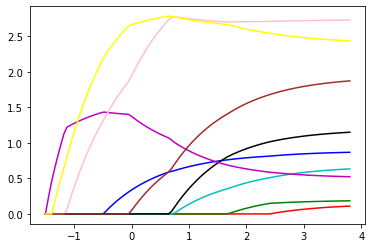

In [26]:
# Make a new, reduced design matrix 
Xnew = X[["age", "height_cm", "weight_kg", "pac", "sho", "pas", "dri", "def", "phy"]]

scaler = sk.preprocessing.StandardScaler(with_mean=True, with_std=True)
Xnew_scl = scaler.fit_transform(Xnew)


# Create a lasso path 
eps = 5e-3  #The smaller eps, the longer the path
lambda_lasso, coefs_lasso, _ = lasso_path(Xnew_scl, y, eps=0.005, n_alphas = 100, alphas = None, fit_intercepr = True)

print(f"minimum regularization parameter :{np.amin(lambda_lasso)}")
print(f"maximum regularization parameter :{np.amax(lambda_lasso)}")

print('The neg_log for min lambda and max lambda is :')
print(-np.log(np.amin(lambda_lasso)))
print(-np.log(np.amax(lambda_lasso)))

# Plot the lasso path
colors = ['b', 'r', 'g', 'c', 'k', 'm', 'pink', 'brown', 'yellow']

neg_log_lambda = -np.log(lambda_lasso)
for i in range(9):
    l1 = plt.plot(neg_log_lambda, coefs_lasso[i,], c=colors[i])

**Written answer here** by increasing `lambda` from 0.022 with neg_log of 3.799 the  `height` is shown with the red color is dropping first and the `pas` parameter is lasting the longest.  

## Question 9: Tuning the lasso coefficient 
We now want to find a model that is both simple (explainable), but at the same time yields still relatively decent predictions. To assess this, vary the regularization constant of the lasso model between exp(2) end exp(-3.5). That is, vary negative log lambda between -2 and 3.5 in even steps. 
Plot the crossvalidation error (mean squared error) against negative-log-lambda of the model. 

Hint: You can either program a for-loop as in Question 6, or use the function `GridSearchCV`. 

What is the simplest model that still gives you a expected validation error of below 15? 
If you wanted the best validation error, what $\lambda$ would you need to use?

,age,height_cm,weight_kg,pac,sho,pas,dri,def,phy
neg_log_alpha,,,,,,,,,
-2,0,0,0,0,0,0,0,0,0
-1.7,0,0,0,0,0,0,0,0,0
-1.4,0,0,0,0,0,0.3,0,0,0
-1.1,0,0,0,0,0,1.2,0.073,0,0.7
-0.84,0,0,0,0,0,1.3,0.77,0,1.5
-0.55,0,0,0,0,0,1.4,1.3,0,2
-0.26,0.22,0,0,0,0,1.3,1.7,0,2.4
0.026,0.39,0,0,0,0,1.3,2.1,0.047,2.6
0.32,0.51,0,0,0,0,1.1,2.5,0.32,2.7


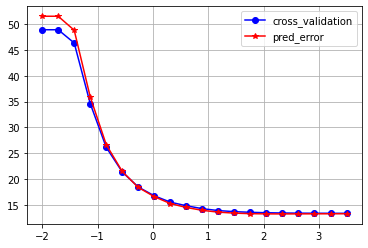

In [34]:
# Your code here
lam = np.exp(np.linspace(2, -3.5, 20)) 
cv_error = np.zeros(20)
pred_error = np.zeros(20)
coeffs = np.zeros((20,9))

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnew_scl, y, test_size= 500, random_state = 0)


for i in range(lam.size):
    cv_error[i]=-cross_val_score(Lasso(alpha=lam[i]), Xtrain, ytrain, cv=10, scoring='neg_mean_squared_error').mean()
    las = Lasso(alpha=lam[i], fit_intercept = True) 
    las.fit(Xtrain, ytrain)
    ypp = las.predict(Xtest)
    pred_error[i] = mse(ytest, ypp)
    coeffs[i] = las.coef_
    
plt.plot(-np.log(lam),cv_error, 'o-b', label='cross_validation')
plt.plot(-np.log(lam),pred_error, '*-r', label='pred_error')
plt.grid()
plt.legend()
# print(las.coef_)


coef_mat = pd.DataFrame(coeffs)
pd.options.display.float_format = '{:,.2g}'.format
coef_mat.index = -np.log(lam)
coef_mat.index.name = 'neg_log_alpha'
coef_mat.columns = ["age", "height_cm", "weight_kg", "pac", "sho", "pas", "dri", "def", "phy"]
coef_mat
################
# las = Lasso(alpha=lam[i], fit_intercept = True)

# GridSearchCV(las, Xtrain, scoring='neg_mean_squared_error', cv = 10)

In [33]:
print(f"The min validation error is: {cv_error.min()}")
# m = np.where(cv_error = cv_error.min)
m = cv_error.tolist().index(cv_error.min())

print(f"The log_lambda related to the lowest cv error is: {np.exp(np.log(lam[m]))}")

print(f"The simplest model with cv less than 15 is when lambda= {np.exp(-0.61)}")

The min validation error is: 13.361646963142135
The log_lambda related to the lowest cv error is: 0.0301973834223185
The simplest model with cv less than 15 is when lambda= 0.5433508690744998


**Written answer here** when `lambda`=0.54 we have 6 features and the cross validation is still bello 15.

## Question  10: Lasso vs. Ridge
In this quesiton, we will compare Ridge regression and Lasso solutions on the model defined in Question 8. Make sure you are using a standardized design matrix for this task. 

Fit the model using Ridge (L2- regularization, $\lambda = exp(-3)$) and Lasso (L1-regularization, $\lambda = exp(-0.5)$. Then print out the regression coefficients for each of the nine features in the design matrix. 

Based on the coefficients, which one is the most important feature in the Ridge vs. Lasso solution? How many features are contributing to the prediction for each solution? How can this difference be explained? 


In [37]:
# Your code here
ridge = Ridge(alpha=np.exp(-3), fit_intercept = True) 
ridge.fit(Xtrain, ytrain)
yp_ridge = ridge.predict(Xtest)

las = Lasso(alpha=np.exp(-0.5), fit_intercept = True) 
las.fit(Xtrain, ytrain)
yp_las = las.predict(Xtest)

print(f"the ridge coefs are: {ridge.coef_.round(4)}")
print(f"the Lasso coefs are: {las.coef_.round(4)}")

the ridge coefs are: [0.9281 0.2501 0.1732 0.7794 1.1696 0.4245 2.8304 1.9034 2.3329]
the Lasso coefs are: [0.5735 0.     0.     0.     0.     1.0362 2.6956 0.4625 2.7164]


**Written answer here** The two biggest coef in ridge correspond to `dri` and `phy` respectively where in lasso the biggest coef if for `phy` and then `dri` feature. Both features have almost equal effect in lasso whereas in ridge the effect of `dri` is %21 higher.

The smallest coefs in ridge are corresponding to `height` and `weight` which are both shrunken to zero in lasso.

 (2.83041767-2.33290471)/2.33290471